# Прогнозирование среднемесячной заработной платы в России

Известны среднемесячные значения заработной платы за 1993-2016 год.

In [2]:
# Импортируем необходимые библиотеки

%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/devvindan/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


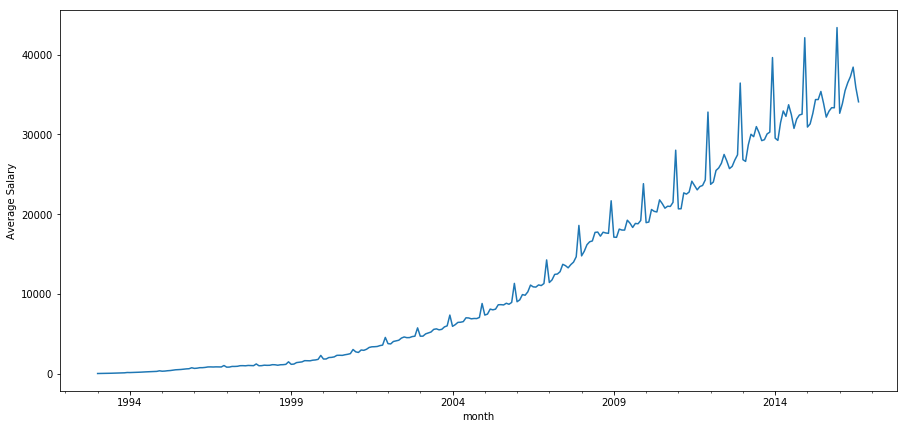

In [7]:
# Импортируем данные, строим графики

salary = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.rename({ "WAG_C_M" : "value" }, axis="columns", inplace=True)
plt.figure(figsize(15,7))
salary.value.plot()
plt.ylabel('Average Salary')
pylab.show()

In [8]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.value)[1])

Критерий Дики-Фуллера: p=0.991850


Имеется тренд, сезоннность, дисперсия растёт со временем. Применим преобразование Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


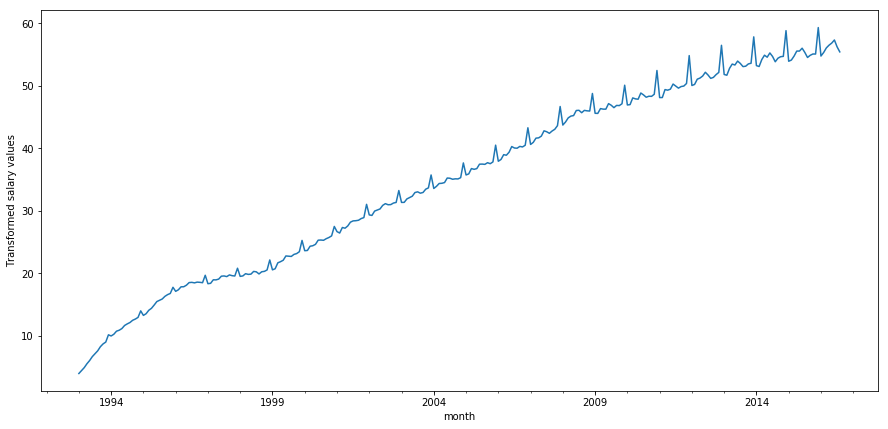

In [9]:
salary['value_box'], lmbda = stats.boxcox(salary.value)
plt.figure(figsize(15,7))
salary.value_box.plot()
plt.ylabel(u'Transformed salary values')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.value_box)[1])

Гипотеза всё так же не отвергается. Проведём сезонное дифференциирование: 

Критерий Дики-Фуллера: p=0.014697


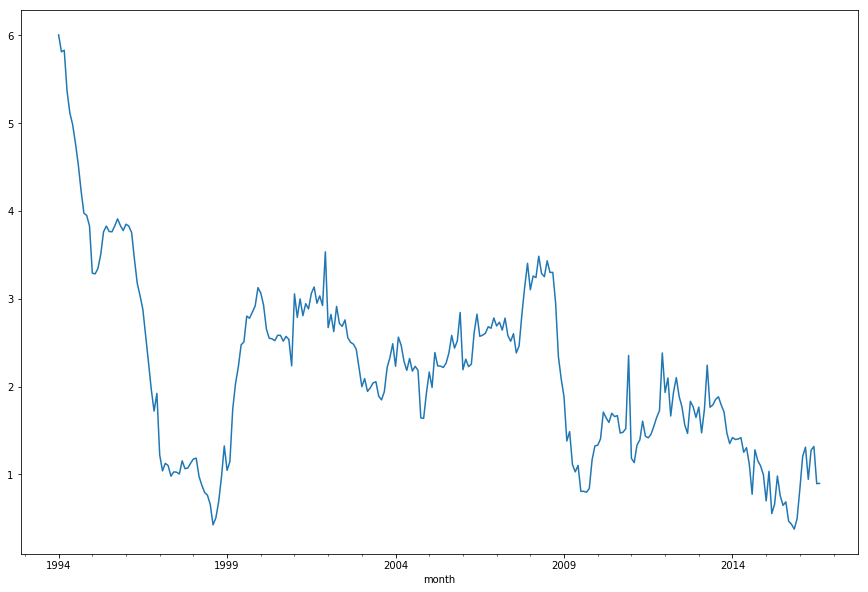

In [11]:
salary['value_box_diff'] = salary.value_box - salary.value_box.shift(12)
plt.figure(figsize(15,10))
salary.value_box_diff[12:].plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.value_box_diff[12:])[1])

Похоже, в данных после сезонного дифференциирования всё ещё присутствует тренд. Применим обычное дифференциирование:

Критерий Дики-Фуллера: p=0.000000


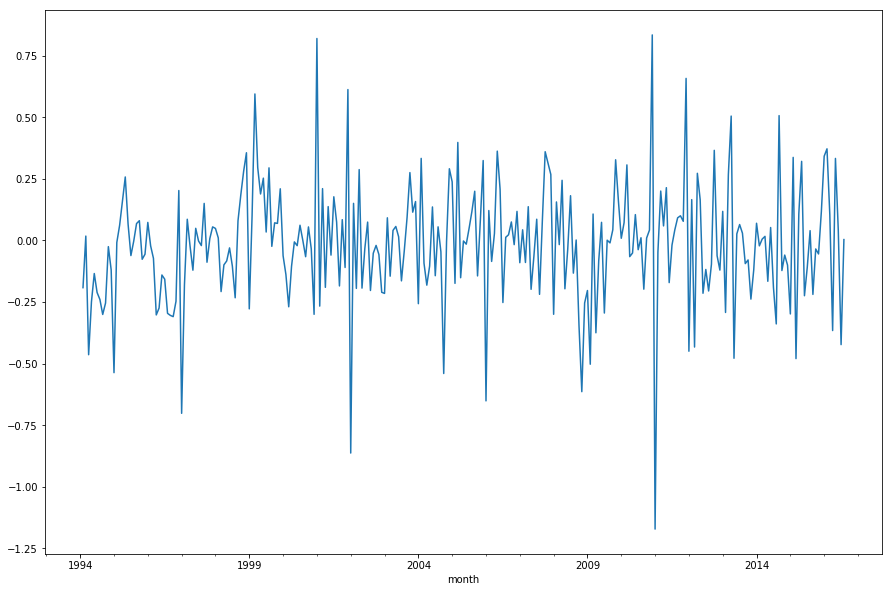

In [13]:
salary['value_box_diff2'] = salary.value_box_diff - salary.value_box_diff.shift(1)
plt.figure(figsize(15,10))
salary.value_box_diff2[13:].plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.value_box_diff2[13:])[1])

От тренда удалось избавиться, критерий Дики-Фуллера подтверждает стационарность данных.

Для подбора модели используем графики (частичной) автокорреляции.

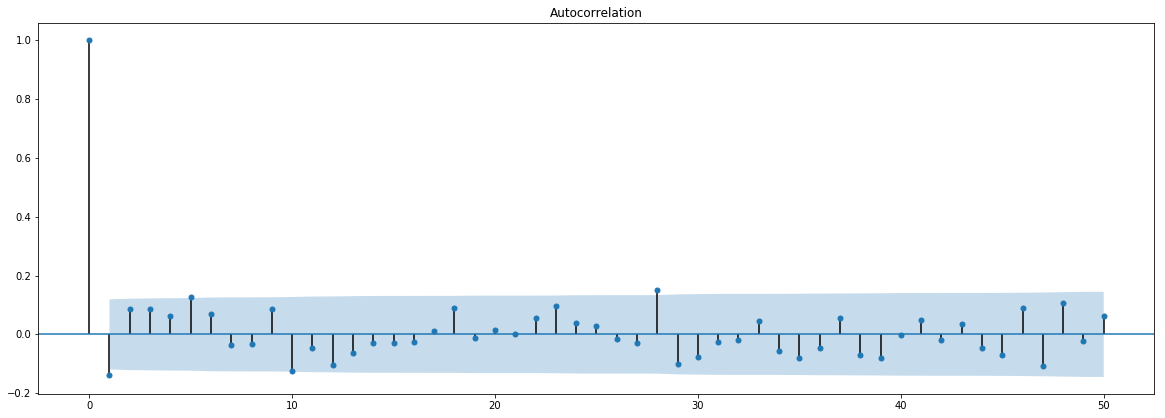

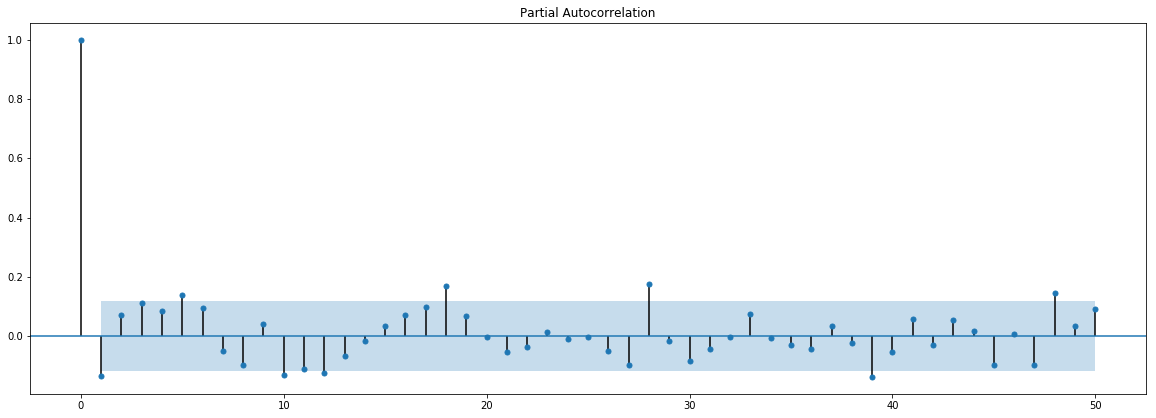

In [20]:
plt.figure(figsize(20,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.value_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.value_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Начальные приближения: Q = 0, q = 1, P = 4, p = 10

In [21]:
ps = range(0, 11)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [24]:
# комбинации значений параметров

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

110

In [26]:
# обучаем модель

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.value_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))


In [27]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters       aic
56    (6, 0, 1, 0) -7.552970
101  (10, 1, 1, 0) -7.168052
57    (6, 0, 2, 0) -6.480323
59    (6, 0, 4, 0) -6.327815
100  (10, 1, 0, 0) -5.958378


In [28]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          value_box   No. Observations:                  284
Model:             SARIMAX(6, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  11.776
Date:                            Fri, 03 Aug 2018   AIC                             -7.553
Time:                                    13:11:11   BIC                             21.264
Sample:                                01-01-1993   HQIC                             4.017
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1991      0.045     -4.401      0.000      -0.288      -0.110
ar.L2          0.0224      0.066   

Остатки модели:

Критерий Стьюдента: p=0.293125
Критерий Дики-Фуллера: p=0.000000


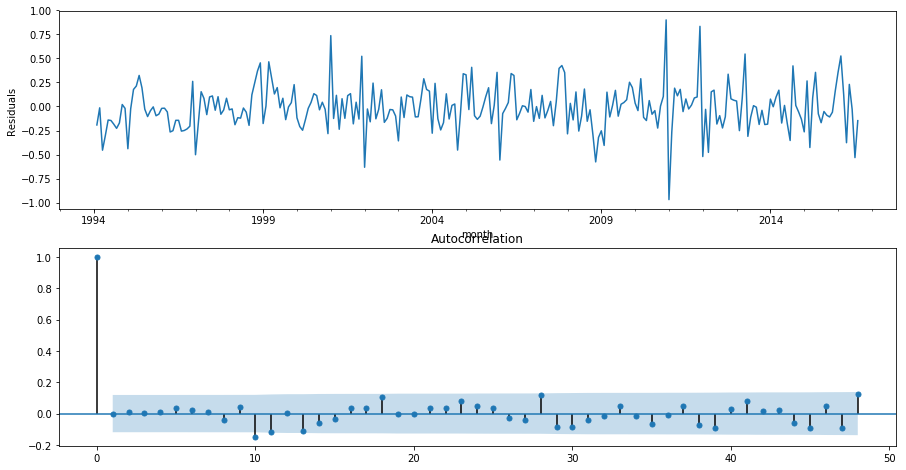

In [29]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены, нестационарны, неавтокоррелированы

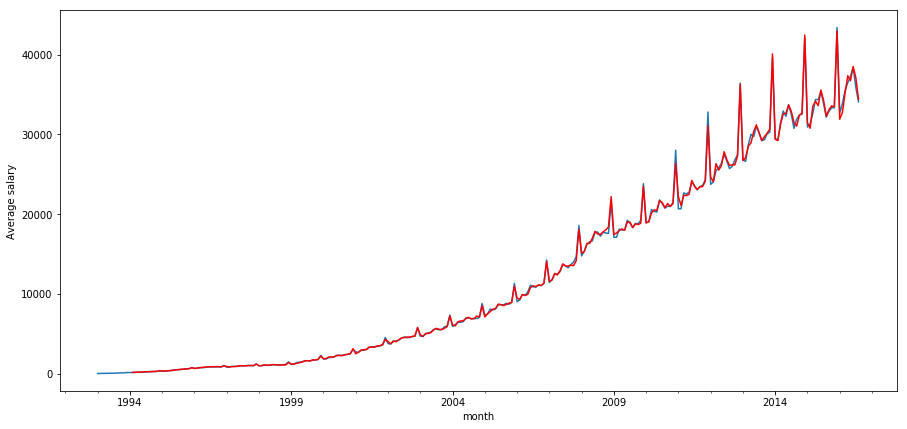

In [31]:
# Выполняем обратное преобразование, чтобы описать данные
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.value.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Average salary')
pylab.show()

Как мы видим, модель достаточно хорошо описывает данные

In [33]:
salary.tail()

,value,value_box,value_box_diff,value_box_diff2,model
month,,,,,
2016-04-01,36497.0,56.526742,0.942729,-0.366210,37370.976533
2016-05-01,37270.0,56.860441,1.275065,0.332336,36735.550222
2016-06-01,38447.0,57.358885,1.316994,0.041929,38516.712439
2016-07-01,35888.0,56.260153,0.893671,-0.423323,37110.806149
2016-08-01,34095.0,55.455409,0.896620,0.002949,34418.219893


In [35]:
salary.shape

(284, 5)

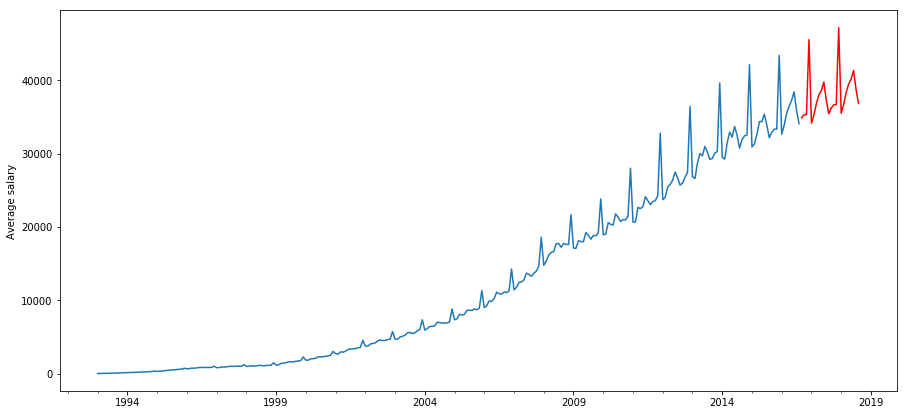

In [36]:
# Строим прогноз
salaries_pred = salary[['value']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salaries_pred.columns)
salaries_pred = pd.concat([salaries_pred, future])
salaries_pred['forecast'] = invboxcox(best_model.predict(start=284, end=284 + (24-1)), lmbda)

plt.figure(figsize(15,7))
salaries_pred.value.plot()
salaries_pred.forecast.plot(color='r')
plt.ylabel('Average salary')
pylab.show()